# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [76]:
# WRITE YOUR CODE HERE
#install.packages('boot')
library(boot)
library(tidyverse)

# read in data
hcp_data <- read.csv('unrestricted_trimmed_1_7_2020_10_50_44.csv')

# select relevant variables and drop NA values
d1 <- hcp_data %>%
  select(c('Subject','Gender','Flanker_Unadj','FS_IntraCranial_Vol','FS_Tot_WM_Vol','FS_Total_GM_Vol')) %>%
  mutate(Gender = as.factor(Gender)) %>%
  drop_na()

head(d1)

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

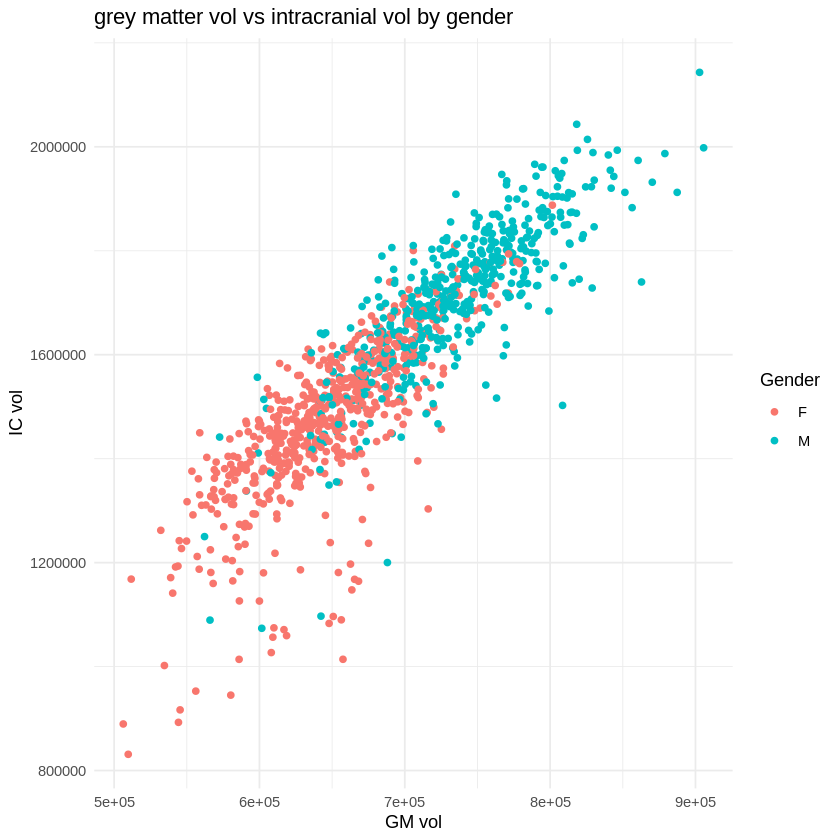

In [ ]:
# WRITE YOUR CODE HERE
ggplot(d1, aes(x = FS_Total_GM_Vol, y = FS_IntraCranial_Vol, color = Gender)) +
  geom_point() +
  theme_minimal() + 
  labs(title = 'grey matter vol vs intracranial vol by gender', x = 'GM vol', y = 'IC vol')

What patterns do you observe in the scatter plot?

> A clear positive linear relationship also exists between GM volume and intracranial volume, with observable separation between males and females. In general, males seem to have both a larger total grey matter volume and larger intracranial volume, likely due to being physcially larger than females on average. 
> 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [ ]:
# WRITE YOUR CODE HERE
logreg_mdl <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data = d1, family = binomial)
summary(logreg_mdl)


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial, data = d1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7695  -0.6173  -0.1863   0.5997   3.2309  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> Based on the logistic regression model, both total GM volume and intracranial volume are significantly associated with gender. 
> 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [94]:
# WRITE YOUR CODE HERE
conf_mat_df <- data.frame(actual = d1$Gender,
                     predicted = rep(NA, length((d1$Gender))))
  
conf_mat_df$predicted <- ifelse(predict(logreg_mdl, type = "response") > 0.5, 'M', 'F') # get continuous predictions

table(conf_mat_df)

acc <- mean(conf_mat_df$predicted == conf_mat_df$actual)

paste('training set accuracy:',acc)

      predicted
actual   F   M
     F 516  90
     M 110 397

[1] "training set accuracy: 0.820305480682839"

What is the prediction accuracy for gender from the full model?

> The full model results in a training set accuracy of 0.82
> 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.8203055 -0.3151644   0.0151102
[1] "[ 0.475525062408398 0.53475705798693 ]"


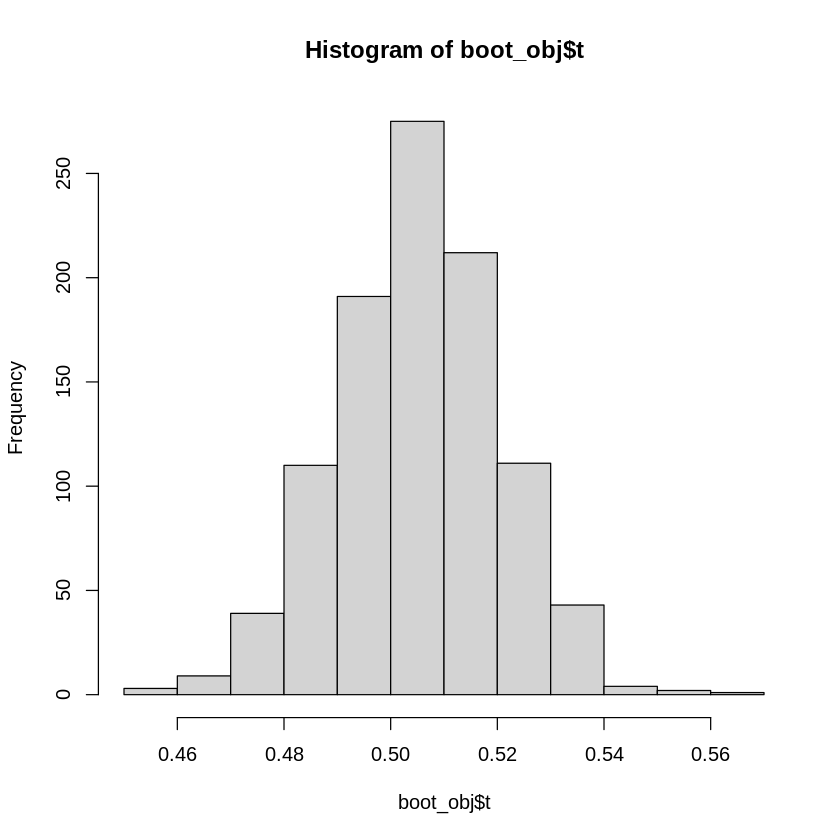

In [74]:
# WRITE YOUR CODE HERE

# write function to return logistic regression coefficients from subset of rows
boot.fn <- function(data, index){  
    # run model on subset of rows
    mdl <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data = data, family = binomial, subset = index)
    
    # set up confusion matrix 
    conf_mat_df <- data.frame(actual = data$Gender,
                     predicted = rep(NA, length((data$Gender))))

    # generate binarized predictions
    conf_mat_df$predicted <- ifelse(predict(mdl, type = "response") > 0.5, 'M', 'F') # get continuous predictions

    # return training accuracy
    return(mean(conf_mat_df$predicted == conf_mat_df$actual))
    }

# perform bootstrap on d1
boot_obj = boot(d1, boot.fn, R=1000)
print(boot_obj)

# generate histogram of bootstrapped accuracies
hist(boot_obj$t)

# calculate 95% CI from bootstrapped standard dev
CI_hi <- mean(boot_obj$t) + 1.96 * sd(boot_obj$t)
CI_lo <- mean(boot_obj$t) - 1.96 * sd(boot_obj$t)

# print 95% CI
print(paste('[',CI_lo,CI_hi,']'))

How robust is the prediction accuracy of the full model?

> Based on 1000 bootstrap iterations, the 95% CI of [0.475525062408398, 0.53475705798693] includes the expectation of 0.5, which corresponds to chance accuracy in 2-class classification. This, coupled with the initial accuracy of 0.82 falling outside the 95% CI seem to indicate that the prediction accuracy of the model is not particularly robust. 
> 

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

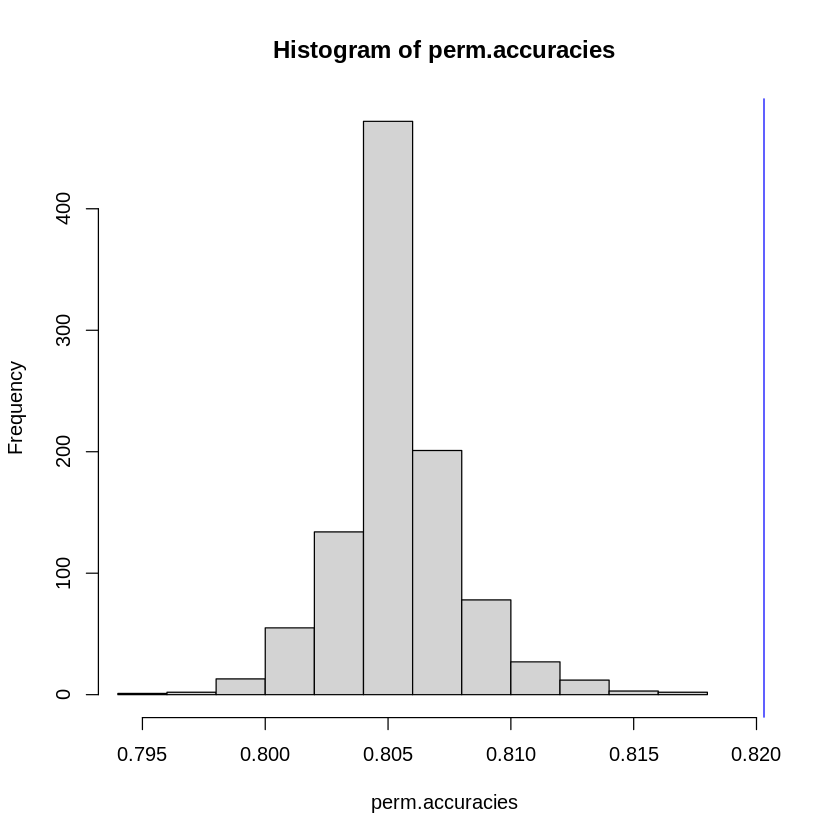

In [108]:
# WRITE YOUR CODE HERE
permutable_d1 <- d1 # retain original data

# set up permutation test parameters
R <- 1000 # number of iterations
perm.accuracies <- matrix(NA,nrow=R, ncol=1) # store permuted accuracies

# main loop of permutation test
for (i in 1:R){
  # permute FS_Total_GM_Vol
  permutable_d1$FS_Total_GM_Vol <- d1$FS_Total_GM_Vol[sample(length(d1$FS_Total_GM_Vol))]

  # fit model with permuted GM vol
  permuted_mdl <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data = permutable_d1, family = binomial)

  # set up confusion matrix 
  conf_mat_df <- data.frame(actual = d1$Gender,
                     predicted = rep(NA, length((d1$Gender))))

  # generate binarized predictions
  conf_mat_df$predicted <- ifelse(predict(permuted_mdl, type = "response") > 0.5, 'M', 'F') # get continuous predictions

  # return training accuracy
  perm.accuracies[i,] <- mean(conf_mat_df$predicted == conf_mat_df$actual)
}

# generate null histogram and place line at observed accuracy
real.acc <- acc
hist(perm.accuracies, xlim = c(min(perm.accuracies), real.acc))
abline(v = real.acc, col="blue")

How much does the grey matter volume influence the prediction accuracy of the model?

> The training set accuracy of 0.82 falls completely outside the derived null distribution generated by the permutation test. This suggests that grey matter volume exerts significant influence on the prediction accuracy of the model.
> 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> In a permutation test, we scramble the relationship between a given X and Y by sampling X without replacement, essentially shuffling the values of X while preserving the values of Y. We do this a number of times and generate a distribution of a parameter of interest, which we refer to as a null distribution. This is appropriate when attempting to assess whether an observed parameter value falls within what would be expected if no relationship existed between X and Y (called H0).


> In bootstrapping, we create multiple subsets of a given dataset by sampling pairs of X and Y with replacement. We can then generate values for parameters of interest for each of the generated subsets. The distributions on the parameters allow for the calculation of confidence estimates on point estimates of those parameters. This is appropriate when attempting to estimate confidence on observed effects.

**DUE:** 5pm EST, March 29, 2023

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*